## Importing Necessary Libraries and Functions

The first thing we need to do is import the necessary functions and libraries that we will be working with throughout the topic. We should also go ahead and upload all the of the necessary data sets here instead of loading them as we go. We will be using energy production data from PJM Interconnection. They are a regional transmission organization that coordinates the movement of wholesale electricity in parts of the United States. Specifically, we will be focused on a region of Pennsylvania. We will also be using temperature data collected from the National Oceanic and Atmospheric Assocation (NOAA).

In [ ]:
!conda update -n base -c defaults conda

!conda install pandas -y
!conda install numpy -y
!conda install matplotlib -y
!conda install statsmodels -y
!pip install scipy 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

Notice how we added an additional pieces above from the ```statsmodels``` module. We need to build time series models in this milestone and so we will need the above pieces to do so. We will be building exponential smoothing models as well as ARIMA models.

This milestone builds off the previous ones so we should complete the following steps to the first milestone again to have our data prepped and ready to go. We should also rebuild our last model from milestone 3 since that is our foundational model!

## Preparing the Energy and Temperature Data##

First we need to load our weather and energy data sets for cleaning. Let's use the pandas library and the ```read.csv``` function to do this.

In [2]:
# Loading the Needed Data Sets 
weather = pd.read_csv('.../hr_temp_20170201-20200131_subset.csv')
energy = pd.read_csv('.../hrl_load_metered - 20170201-20200131.csv')


It is always good practice to take a look at the first few observations of the data set to make sure that everything looks like how we expected it to when we read in our CSV file. Let's use the ```head``` function for this.

In [3]:
weather.head()

,STATION,DATE,REPORT_TYPE,SOURCE,HourlyDryBulbTemperature
0,72520514762,2017-02-01T00:53:00,FM-15,7,37.0
1,72520514762,2017-02-01T01:53:00,FM-15,7,37.0
2,72520514762,2017-02-01T02:53:00,FM-15,7,36.0
3,72520514762,2017-02-01T03:53:00,FM-15,7,36.0
4,72520514762,2017-02-01T04:53:00,FM-15,7,36.0


Perfect! We have temperature as well as time. There are some other pieces of information like the station number, source of the reading and reading type, but we don't need those.

Let's take a look at the first few observations of the energy data as well!

In [4]:
energy.head()

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,2/1/2017 5:00,2/1/2017 0:00,RFC,WEST,DUQ,DUQ,1419.881,True
1,2/1/2017 6:00,2/1/2017 1:00,RFC,WEST,DUQ,DUQ,1379.505,True
2,2/1/2017 7:00,2/1/2017 2:00,RFC,WEST,DUQ,DUQ,1366.106,True
3,2/1/2017 8:00,2/1/2017 3:00,RFC,WEST,DUQ,DUQ,1364.453,True
4,2/1/2017 9:00,2/1/2017 4:00,RFC,WEST,DUQ,DUQ,1391.265,True


Great! Again, we have the important information of time as well as megawatt (MW) readings per hour. Again, there are some other varibales that we won't end up using in this data set as well.

Let's get rid of the variables we don't need and combine the variables that we do need into one pandas data frame. Dictionaries are an easy way of doing this. Here, we are pulling the MW column from the energy data set as well as the temperature and date columns from the weather data set. These data sets already line up on time which makes this much easier.

In [5]:
d = {'MW': energy['mw'], 'Temp': weather['HourlyDryBulbTemperature'], 'Date': weather['DATE']}

Now let's create our pandas data frame.

In [6]:
df = pd.DataFrame(d)

One of the problems when loading a data set you want to run time series analysis on is the type of object Python sees for the "date" variable. Let's look at the pandas data frame data types for each of our variables.

In [7]:
print(df.dtypes)

MW      float64
Temp    float64
Date     object
dtype: object


Here we can see that the Date variable is a general object and not a "date" according to Python. We can change that with the pandas function ```to_datetime``` as we have below.

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
print(df.dtypes)

MW             float64
Temp           float64
Date    datetime64[ns]
dtype: object


Good! Now that we have a ```datetime64``` object in our data set we can easily create other forms of date variables. The hour of day, day of week, month of year, and possibly even the year itself might all impact the energy usage. Let's extract these variables from our date object so that we can use them in our analysis. Pandas has some wonderful functionality to do this with the ```hour```, ```day```, ```dayofweek```, ```month```, and ```year``` functions. Then let's inspect the first few observations to make sure things look correct.

In [9]:
df['hour'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).hour
df['day'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).day
df['weekday'] = df['Date'].dt.dayofweek
df['month'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).month
df['year'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).year

df.head()

,MW,Temp,Date,hour,day,weekday,month,year
0,1419.881,37.0,2017-02-01 00:53:00,0,1,2,2,2017
1,1379.505,37.0,2017-02-01 01:53:00,1,1,2,2,2017
2,1366.106,36.0,2017-02-01 02:53:00,2,1,2,2,2017
3,1364.453,36.0,2017-02-01 03:53:00,3,1,2,2,2017
4,1391.265,36.0,2017-02-01 04:53:00,4,1,2,2,2017


Everything looks good in the first few observations above. If you still aren't convinced you could pull different pieces of the data frame to make sure that other observations are structured correctly.

Now we should set this Python date object as the index of our data set. This will make it easier for plotting as well as forecasting later. We can use the ```set_index``` function for this.

In [10]:
df = df.set_index('Date')

Good! Now that we have our data structured as we would like, we can start the cleaning of the data. First, let's check if there are any missing values in the temperature column. The ```is.null``` function will help us here.

In [11]:
sum(df['Temp'].isnull())

37

Looks like there are 37 missing values in our temperature data. We shoudl impute those. However, we don't just want to put the average temperature in these spots as the overall average across three years probably isn't a good guess for any one hour. The temperature of the hours on either side of the missing observation would be more helpful. Let's do a linear interpolation across missing values to help with this. This will essentially draw a straight line between the two known points to fill in the missing values. We can use the ```interpolate(method='linear')``` function for this.

In [12]:
df['Temp'] = df['Temp'].interpolate(method='linear')

Now let's see if we have any more missing temperature values.

In [13]:
sum(df['Temp'].isnull())

0

No more! Time to check if the energy data has any missing values.

In [14]:
sum(df['MW'].isnull())

0

No missing values there either! Perfect.

Now it is time to split the data into two pieces - training and testing. The training data set is the data set we will be building our model on, while the testing data set is what we will be reporting results on since the model wouldn't have seen it ahead of time. Using the date index we can easily do this in our data frame.

In [15]:
#Training and Validation Split #
train = pd.DataFrame(df['2017-01-01':'2019-12-31'])
test = pd.DataFrame(df['2020-01-01':'2020-01-31'])

Now let's look at the first few observations for our training data set.

In [16]:
train.head()

,MW,Temp,hour,day,weekday,month,year
Date,,,,,,,
2017-02-01 00:53:00,1419.881,37.0,0,1,2,2,2017
2017-02-01 01:53:00,1379.505,37.0,1,1,2,2,2017
2017-02-01 02:53:00,1366.106,36.0,2,1,2,2,2017
2017-02-01 03:53:00,1364.453,36.0,3,1,2,2,2017
2017-02-01 04:53:00,1391.265,36.0,4,1,2,2,2017


Everything looks good there!

Now let's do the same for our testing data set.

In [17]:
test.head()

,MW,Temp,hour,day,weekday,month,year
Date,,,,,,,
2020-01-01 00:53:00,1363.428,31.0,0,1,2,1,2020
2020-01-01 01:53:00,1335.975,29.0,1,1,2,1,2020
2020-01-01 02:53:00,1296.817,30.0,2,1,2,1,2020
2020-01-01 03:53:00,1288.403,30.0,3,1,2,1,2020
2020-01-01 04:53:00,1292.263,31.0,4,1,2,1,2020


Excellent! We now have our data cleaned and split. By combining and cleaning the data sets, we will make the exploration of these data sets as well as the modeling of these data sets much easier for the upcoming sections!

## Building Naive Energy Model

Now that we have recreated the pieces of milestone 1 that clean and split our data we can start the modeling phase of milestone 3.

First, let's review some of the findings we have from the first two milestones:
- Energy usage changes depending on month / season
- Energy usage changes depending on day of week
- Energy usage changes depending on hour of day
- Energy usage changes depending on outside temperature
- The relationship between temperature and energy usage appears quadratic in nature

Looking at this last bullet point, we need to create a quadratic variable on temperature as temperature in the model by itself won't be enough to model energy usage. It is always good practice to standardize (mean of 0 and standard deviation of 1) any variable you are going to raise to a higher power in a regression to help prevent multicollinearity problems. We can standardize the variable *Temp* by using the ```mean``` and ```std``` functions.

In [18]:
train['Temp_Norm'] = (train['Temp']-train['Temp'].mean())/train['Temp'].std()

Now that temperature is standardized (or normalized) we can just multiply it by itself to get our quadratic term.

In [19]:
train['Temp_Norm2'] = train['Temp_Norm']**2

Let's do a brief look at the first few observations in our training data set to make sure that things worked as expected.

In [20]:
train.head()

,MW,Temp,hour,day,weekday,month,year,Temp_Norm,Temp_Norm2
Date,,,,,,,,,
2017-02-01 00:53:00,1419.881,37.0,0,1,2,2,2017,-0.871499,0.759511
2017-02-01 01:53:00,1379.505,37.0,1,1,2,2,2017,-0.871499,0.759511
2017-02-01 02:53:00,1366.106,36.0,2,1,2,2,2017,-0.924494,0.854690
2017-02-01 03:53:00,1364.453,36.0,3,1,2,2,2017,-0.924494,0.854690
2017-02-01 04:53:00,1391.265,36.0,4,1,2,2,2017,-0.924494,0.854690


In [21]:
results = sm.OLS.from_formula('MW ~ Temp_Norm*C(hour) + Temp_Norm2*C(hour) + Temp_Norm*C(month) + Temp_Norm2*C(month) + C(weekday)*C(hour)', 
                              data=train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     MW   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     1248.
Date:                Fri, 09 Oct 2020   Prob (F-statistic):               0.00
Time:                        12:43:23   Log-Likelihood:            -1.4774e+05
No. Observations:               25536   AIC:                         2.960e+05
Df Residuals:                   25287   BIC:                         2.980e+05
Df Model:                         248                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

All of those terms appeared significant too! Excellent. Now we have our naive energy model. It takes into account the hour of day, day of week, month of year, and the complicated relationship with temperature. 

Time to see how good our predictions are. One evaluation of model performance is the mean absolute percentage error (MAPE). This evaluates on average how far off are our predictions in terms of percentages. We need to get our predictions from our training data set. The ```fittedvalues``` function will do that for us. Then we can calculate the MAPE ourselves.

In [22]:
train['fitted'] = results.fittedvalues

train['APE'] = abs((train['MW']-train['fitted'])/train['MW'])*100
print("Training Naive Model MAPE is: ", train['APE'].mean())

Training Naive Model MAPE is:  3.5119541032055452


On average, our model incorrectly predicted energy usage by a little over 3.5%! That gives us a good baseline to compare our future models with.



In [23]:
test['Temp_Norm'] = (test['Temp']-test['Temp'].mean())/test['Temp'].std()
test['Temp_Norm2'] = test['Temp_Norm']**2

Let's forecast out our model by scoring the test data set with the linear regression we built. Remember, we don't want to build a model on the test data set, just run the observations through the equation we got from the training model. These are our January 2020 predictions! The ```predict``` function will help us with this. We need to specify which data set we are predicting as you see with the ```predict(test)``` below. Let's look at the first few observations from this prediction!

In [24]:
test['pred'] = results.predict(test)

test.head()

,MW,Temp,hour,day,weekday,month,year,Temp_Norm,Temp_Norm2,pred
Date,,,,,,,,,,
2020-01-01 00:53:00,1363.428,31.0,0,1,2,1,2020,-0.435454,0.189621,1301.224887
2020-01-01 01:53:00,1335.975,29.0,1,1,2,1,2020,-0.627840,0.394184,1296.150033
2020-01-01 02:53:00,1296.817,30.0,2,1,2,1,2020,-0.531647,0.282649,1280.104337
2020-01-01 03:53:00,1288.403,30.0,3,1,2,1,2020,-0.531647,0.282649,1292.227132
2020-01-01 04:53:00,1292.263,31.0,4,1,2,1,2020,-0.435454,0.189621,1334.757899


Good! Now let's plot our predictions for the test data set against the actual values.

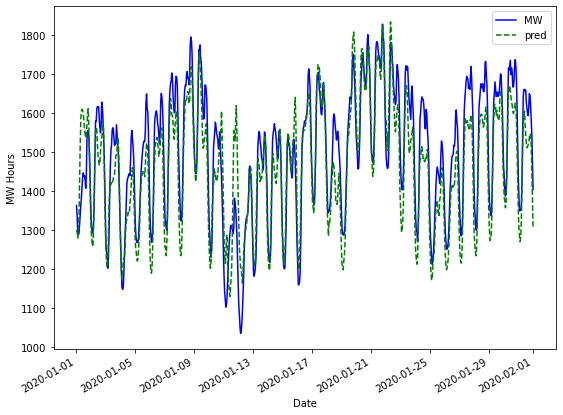

In [25]:
test['MW'].plot(color = 'blue', figsize=(9,7))

plt.ylabel('MW Hours')
plt.xlabel('Date')

test['pred'].plot(color = 'green', linestyle = 'dashed', figsize=(9,7))

plt.legend(loc="best");

plt.show()

Those look like rather good predictions! Let's see what the MAPE is on these.

In [26]:
test['APE'] = abs((test['MW']-test['pred'])/test['MW'])*100
print("Naive Model MAPE is: ", test['APE'].mean())

Naive Model MAPE is:  4.3947190107463365


Great! Remember, the MAPE is probably going to be higher because our model hasn't seen this data before. This is a great way to truly evaluate how well your model will do when deployed in a real world setting since you won't know energy data before you predict it. Looks like our model is only off by 4.4% on average.

The foundation is laid in this step. Model building can be complicated and sometimes it is hard to know when to stop. The best plan is to build a foundational model that you can try to build upon and/or outperform with later editions of your model. Without a good baseline, you won't know how good your final model is. These seasonal effects of hours of day, days of week, months of year as well as the temperature effects build a great first attempt at forecasting future energy usage.

This is a great initial model if your boss needs a check-in to see your progress. This model gets you a long way there since you have incorporated temperature's complicated relationship. In the next milestones you get to build on this great foundation to really show your boss what you can do!

## Dynamic Time Series Model

Now that we have recreated the important pieces of milestones 1 and 3, we can move on to milestone 4's objectives. 

We have a great foundational, naive energy model. This model accounts for the energy's relationship with hour of day, day of week, month of year, and the complicated relationship with temperature. However, previous values of energy usage probably play some impact on the prediction of current energy usage. This is the basis for time series modeling!

First, we need to get the residuals from the naive energy model. We will use these residuals as inputs to our dynamic time series model. We can use the ```resid``` function to do this.

In [27]:
train['resid'] = results.resid

Just like with our original energy data, let's plot the residuals from our model to see what we have.

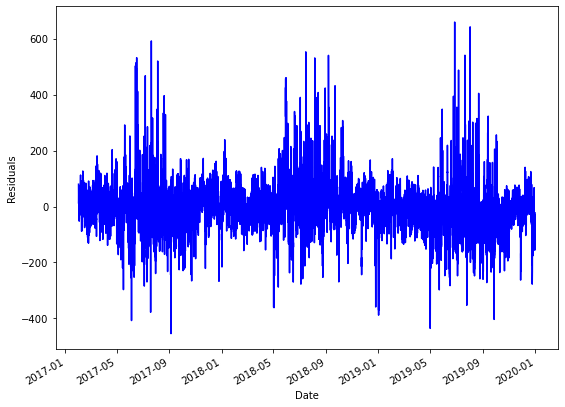

In [28]:
ax1 = train['resid'].plot(color = 'blue', figsize=(9,7))

ax1.set_ylabel('Residuals')
ax1.set_xlabel('Date')

plt.show()

Looks like we still see the seasonal effects that we had in our original data. Summer months seem to have bigger residuals (model errors) than the rest of the year. 

Let's zoom in on a specific week from December to see what our residuals look like.

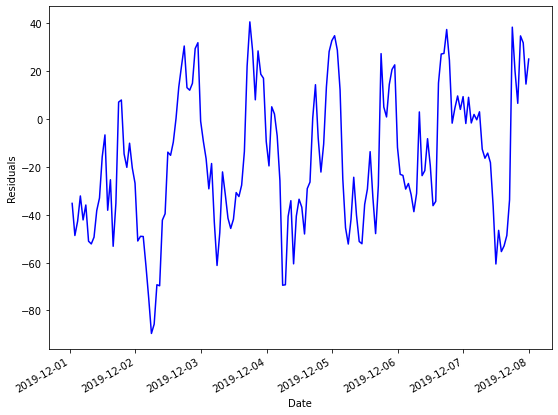

In [29]:
ax1 = train['2019-12-01':'2019-12-07']['resid'].plot(color = 'blue', figsize=(9,7))

ax1.set_ylabel('Residuals')
ax1.set_xlabel('Date')

plt.show()

It appears that we still have some daily effects as well. Different hours of the day we do worse at predicting energy than other hours. Let's see if time series models can help us correct this!

### Exponential Smoothing Models 

#### Winters Seasonal Exponential Smoothing Model 

Exponential smoothing models can be used to predict a variety of different types of data. There are different models depending on whether our data is trending and/or contains a seasonal effect as well. The Winters exponential smoothing model accounts for seasonal effects while the Holt exponential smoothing model accounts for trend. Since our residuals don't trend, but still have a seasonal effect we should use the Winter's Seasonal Exponential Smoothing Model. Let's try to forecast our energy residuals with this model!

The ```ExponentialSmoothing``` function will help us with this. Remember that we don't want a trend. Also, since our data is hourly and appears we have a daily effect, we set the seasonal periods to 24. You can play around with either an additive (```seasonal='add'```) or multiplicative (```seasonal='mult'```) effect. Use the resources provided with the milestone if you are interested in learning the difference between those!

In [30]:
mod_tes = ExponentialSmoothing(train['resid'], trend=None, seasonal='add', seasonal_periods=24)

res_tes = mod_tes.fit()
print(res_tes.summary())

C:\Users\adlabarr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                25536
Model:             ExponentialSmoothing   SSE                       35226454.604
Optimized:                         True   AIC                         184663.578
Trend:                             None   BIC                         184875.422
Seasonal:                      Additive   AICC                        184663.641
Seasonal Periods:                    24   Date:                 Fri, 09 Oct 2020
Box-Cox:                          False   Time:                         12:43:36
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8841008                alpha                 True
smoothing_seasonal       

We can then use the ```forecast``` functions to forecast out the month of January which is 744 observations. Careful though. These forecasts are the **residuals**.

C:\Users\adlabarr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


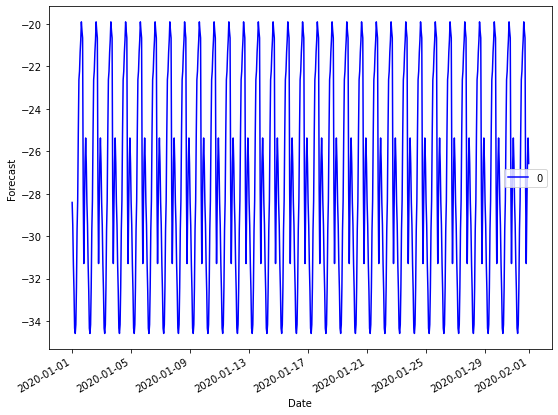

In [31]:
forecast = pd.DataFrame(res_tes.forecast(744))
forecast.index = test.index.copy()

ax1 = forecast.plot(color = 'blue', figsize=(9,7))

ax1.set_ylabel('Forecast')
ax1.set_xlabel('Date')

plt.show()

Let's go ahead and save these model fitted values (from the training data) and forecasts (the test data) to our respective data frames. That way we can evaluate them best.

In [32]:
train['fitted_resid'] = res_tes.fittedvalues
test['pred_resid'] = forecast

Our energy forecast isn't the residual forecast. It is the combination the forecast from the naive model **and** the new exponential smoothing model on the residuals. Add these two forecasts together to get your new dynamic energy model forecasts for each the training and test data sets. 

In [33]:
train['fitted_ESM'] = train['fitted'] + train['fitted_resid']
test['pred_ESM'] = test['pred'] + test['pred_resid']

Now let's view our forecast just like we did with the naive model!

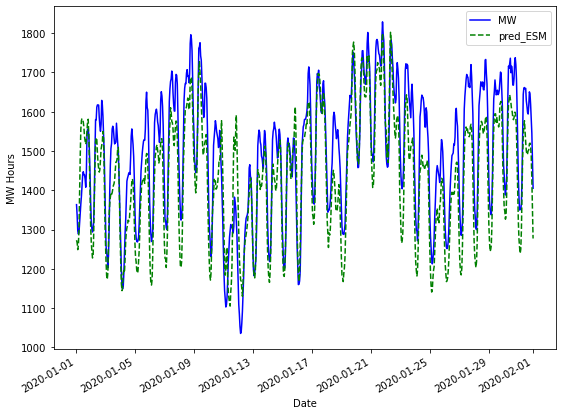

In [34]:
test['MW'].plot(color = 'blue', figsize=(9,7))

plt.ylabel('MW Hours')
plt.xlabel('Date')

test['pred_ESM'].plot(color = 'green', linestyle = 'dashed', figsize=(9,7))

plt.legend(loc="best");

plt.show()

Just like with the naive model, let's calculate the MAPE for our new dynamic energy model using exponential smoothing. First let's do this on the training data.

In [35]:
train['APE_ESM'] = abs((train['MW']-train['fitted_ESM'])/train['MW'])*100
print("Training Naive + ESM Model MAPE is: ", train['APE_ESM'].mean())

Training Naive + ESM Model MAPE is:  1.4789918216232285


Wow! Our naive model had a training data set of about 3.5%, but this is down to nearly 1.5%! Our model seems to have improved. Let's check the test data set though and calculate a MAPE there.

In [36]:
test['APE_ESM'] = abs((test['MW']-test['pred_ESM'])/test['MW'])*100
print("Naive + ESM Model MAPE is: ", test['APE_ESM'].mean())

Naive + ESM Model MAPE is:  5.458113823008118


So we didn't see as much improvement in the test data set, but we still have some promise here based on the training data set improvement. 

Exponential smoothing models aren't the only time series models we could use. Instead of using ESM's we could try another class of time series model - the ARIMA model.

### ARIMA Model

#### Model Selection

There are many techniques to building ARIMA models. Classical approaches involve looking at correlation functions. More modern approaches use computer algorithms to build grids of models and compare. The nuances of these approaches are discussed in the resources provided. A brief outline is given here.

Looking at the correlation patterns of the data across time can reveal the best underlying model for the data. There are two correlation functions that we need to look at to get the full picture:
 1. Autocorrelation Function (ACF)
 2. Partial Autocorrelation Function (PACF)

Let's look at the ACF of our data with the ```plot_acf``` function.

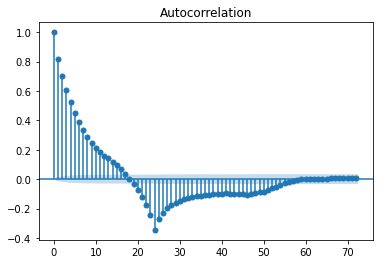

In [37]:
fig = tsaplots.plot_acf(train['resid'].diff(24)[25:], lags = 72)

plt.show()

From this plot we can see an exponentially decreasing pattern. This signals some potential for autoregressive (AR) terms in our model. We also see a random spike at 24. This signals a potential moving average (MA) term as well.

Now let's look at the PACF of the residuals with the ```plot_pacf``` function.

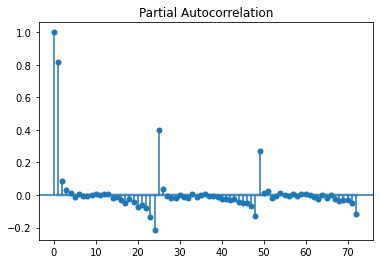

In [38]:
fig = tsaplots.plot_pacf(train['resid'].diff(24)[25:], lags = 72)

plt.show()

We have a couple of spikes early on in this plot followed by a lot of nothing. Definitely an AR patterns with 2 as its order (p = 2 in ARIMA terminology). We also see an exponentially decreasing set of spikes every 24 hours. This coincides with the single spike at 24 from the ACF plot. Definitely a moving average (MA) term at that seasonal period (in ARIMA terminology this is Q = 1).

We also know that our data still has some seasonal effects every 24 hours so we should take a seasonal difference to account for this. 

In [39]:
mod = SARIMAX(train['resid'], order=(2,0,0), seasonal_order=(0,1,1,24))
res = mod.fit()

print(res.summary())

C:\Users\adlabarr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\adlabarr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                      SARIMAX Results                                       
Dep. Variable:                                resid   No. Observations:                25536
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 24)   Log Likelihood             -127287.455
Date:                              Fri, 09 Oct 2020   AIC                         254582.910
Time:                                      12:46:11   BIC                         254615.498
Sample:                                           0   HQIC                        254593.447
                                            - 25536                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8113      0.003    270.427      0.000       0.805       0.817
ar.L2          0.07

Let's take a look at the results that we just got. It appears based on the p-values above that all of our terms are significant which is great. 

Let's forecast out the next 744 hours (our test data set) to see what it looks like. Again, we can use the ```forecast``` function to do this. Remember though, this is only a forecast of our residuals!

C:\Users\adlabarr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


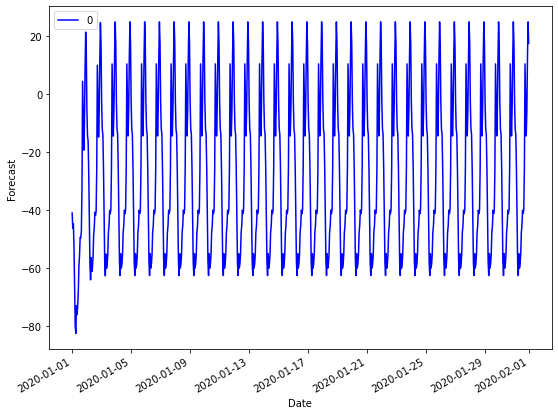

In [40]:
forecast = pd.DataFrame(res.forecast(744))
forecast.index = test.index.copy()

ax1 = forecast.plot(color = 'blue', figsize=(9,7))

ax1.set_ylabel('Forecast')
ax1.set_xlabel('Date')

plt.show()

Just with the ESM model, let's go ahead and save the predicted values and forecasts to our respective data frames. This will make it easier to see how well we did.

In [41]:
train['fitted_resid2'] = res.predict()
test['pred_resid2'] = forecast

Now, let's add these ARIMA forecasts of our residuals to the previous forecasts we developed from our naive energy model to form our dynamic energy model using ARIMA techniques. 

In [42]:
train['fitted_ARIMA'] = train['fitted'] + train['fitted_resid2']
test['pred_ARIMA'] = test['pred'] + test['pred_resid2']

Let's plot this forecast to see how well we did in the test data set.

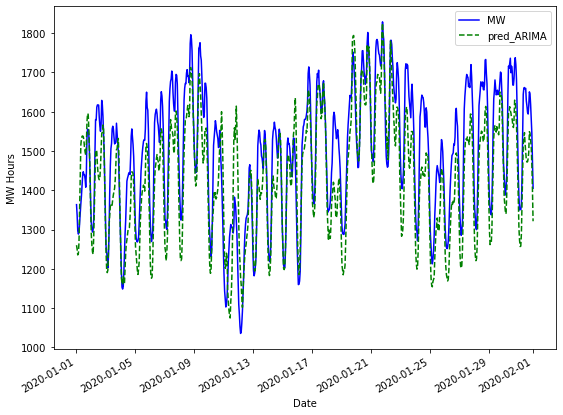

In [43]:
test['MW'].plot(color = 'blue', figsize=(9,7))

plt.ylabel('MW Hours')
plt.xlabel('Date')

test['pred_ARIMA'].plot(color = 'green', linestyle = 'dashed', figsize=(9,7))

plt.legend(loc="best");

plt.show()

It is visually a little hard to determine how well we did in comparison to the other models that we have developed. Let's calculate the MAPE for both our training and testing data sets.

In [44]:
train['APE_ARIMA'] = abs((train['MW']-train['fitted_ARIMA'])/train['MW'])*100
print("Training Naive + ARIMA Model MAPE is: ", train['APE_ARIMA'].mean())

Training Naive + ARIMA Model MAPE is:  1.3663869635441892


Wow! Our naive model had a training data set of about 3.5%, and ESM dynamic model had a MAPE of 1.5%, but this is down to nearly 1.4%! Our model seems to have improved. Let's check the test data set though and calculate a MAPE there.

In [45]:
test['APE_ARIMA'] = abs((test['MW']-test['pred_ARIMA'])/test['MW'])*100
print("Naive + ARIMA Model MAPE is: ", test['APE_ARIMA'].mean())

Naive + ARIMA Model MAPE is:  5.5553216961887655


Again, we didn't see as much improvement in the test data set, but we still have some promise here based on the training data set improvement. 

Feel free to play around with other seasonal ARIMA models to see if you can improve the forecasts! These techniques are memory intensive and time consuming however. Just be prepared for this as you build models. If you are running this in a colab environment, you might need to restart the kernel at each model build because of the memory and time consumption. Local installations might not have this problem. 

One potential improvement to modeling in time series is to ensemble (or average) multiple models' forecasts to make a better forecast. It doesn't always work, but always worth trying since it is rather easy. First, let's take the average of our two residual forecasts and add that to our naive model instead of just picking either the ESM or the ARIMA.

In [46]:
train['fitted_Ensemble'] = train['fitted'] + 0.5*train['fitted_resid'] + 0.5*train['fitted_resid2']
test['pred_Ensemble'] = test['pred'] + 0.5*test['pred_resid'] + 0.5*test['pred_resid2']

Now let's check the MAPE of both the training and testing data sets.

In [47]:
train['APE_Ensemble'] = abs((train['MW']-train['fitted_Ensemble'])/train['MW'])*100
print("Training Naive + Ensemble Model MAPE is: ", train['APE_Ensemble'].mean())

Training Naive + Ensemble Model MAPE is:  1.3776474681630708


In [48]:
test['APE_Ensemble'] = abs((test['MW']-test['pred_Ensemble'])/test['MW'])*100
print("Naive + Ensemble Model MAPE is: ", test['APE_Ensemble'].mean())

Naive + Ensemble Model MAPE is:  5.4762931305278135


Looks like the ensemble didn't do too much to improve our forecasts. If that is the case, it might not be the analytical techniques as much as the variables that go into them. That is what we will be covering in the next milestone!

So many times forecasters will stop at simple regression techniques or only use time series approaches in isolation. The benefit can really be felt by merging the two together as you will do in this milestone. Gaining the benefit of the external variable relationships as well as the correlations across time can greater improve your forecasts and reduce your prediction errors. Now you can really display your analytical talent for your boss. If they were impressed with your last model, then this one should really help drive home the impact you are making in helping them getting more accurate forecasts to improve their business decisions!

#### OPTIONAL Additional Code in ARIMA

Python has some built in functions to try and select ARIMA models automatically. Unfortunately, they use grid search techniques to build many different ARIMA models which as mentioned earlier can be both time and memory intensive. For this reason, we are not going over this function in this course. However, feel free to play around with the code below and investigate more on your own!

In [49]:
#!pip install scipy 
#!pip install pmdarima 

#from pmdarima import auto_arima

#mod_auto = auto_arima(train['resid'], start_p=0, start_q=0, max_p=3, max_q=3, 
                      #start_P=2, start_Q=0, max_P=2, max_Q=0, m=24, 
                      #seaonal=True, trace=True, d=0, D=1, error_action='warn', 
                      #stepwise=True)